In [12]:
# PART 1: IMPORT ALL THE TOOLS I WILL BE USING

# These two are for working with tables (rows/columns) and numbers
import pandas as pd
import numpy as np

# These help to split the data and prepare it
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# These help to measure how good models are
from sklearn.metrics import (
    classification_report,  # shows precision, recall, f1
    roc_auc_score,          # shows AUC score
    roc_curve,              # data for ROC curve
    confusion_matrix        # table of correct / wrong predictions
)

# The machine learning models I will train
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# These are for making plots/graphs
import matplotlib.pyplot as plt
import seaborn as sns

# These are for explainable AI
import shap                      # for SHAP plots
from lime import lime_tabular    # for LIME explanations

# This is to ignore warning messages so the output looks cleaner
import warnings
warnings.filterwarnings("ignore")


In [3]:
import sys
sys.executable


'C:\\Apps\\python.exe'

In [6]:
!C:\Apps\python.exe -m pip install shap


In [9]:
!C:\Apps\python.exe -m pip install lime


In [14]:
# PART 2: LOAD THE METABRIC DATASET

# Here I read the Excel file into a DataFrame called "df"
df = pd.read_excel("Breast Cancer METABRIC Dataset.xlsx")

# Look at the first few rows to understand the data
df.head()


,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [18]:
# PART 3: CREATE A BINARY TARGET COLUMN
#          (1 = Recurred, 0 = Not Recurred)

# I only keep rows where (Relapse Free Status) is NOT missing
df = df.dropna(subset=["Relapse Free Status"])

# I create a new column called (Relapse_Binary)
# - If Relapse Free Status == (Recurred)      -> 1
# - If Relapse Free Status == (Not Recurred) -> 0
df["Relapse_Binary"] = df["Relapse Free Status"].map({
    "Recurred": 1,
    "Not Recurred": 0
})

# Let's see how many patients recurred vs not recurred
df["Relapse_Binary"].value_counts()


Relapse_Binary
0    1486
1    1002
Name: count, dtype: int64

In [20]:
# PART 4: CHOOSE WHICH FEATURES TO USE

# These are numeric features (they are numbers)
num_cols = [
    "Age at Diagnosis",
    "Tumor Size",
    "Tumor Stage",
    "Lymph nodes examined positive",
    "Mutation Count",
    "Nottingham prognostic index"
]

# These are categorical features (text values that represent categories)
cat_cols = [
    "Cellularity",
    "Chemotherapy",
    "ER status measured by IHC",
    "HER2 status measured by SNP6",
    "Hormone Therapy",
    "Radio Therapy",
    "Neoplasm Histologic Grade",
    "Primary Tumor Laterality",
    "3-Gene classifier subtype",
    "Pam50 + Claudin-low subtype"
]

# I combine the lists into one list of all features
feature_cols = num_cols + cat_cols

# I create a smaller DataFrame that only has:
# - the features we chose
# - the target column "Relapse_Binary"
data = df[feature_cols + ["Relapse_Binary"]].copy()

# Let's look at it quickly
data.head()



,Age at Diagnosis,Tumor Size,Tumor Stage,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Radio Therapy,Neoplasm Histologic Grade,Primary Tumor Laterality,3-Gene classifier subtype,Pam50 + Claudin-low subtype,Relapse_Binary
0,75.65,22.0,2.0,10.0,NaN,6.044,NaN,No,Positve,Neutral,Yes,Yes,3.0,Right,ER-/HER2-,claudin-low,0
1,43.19,10.0,1.0,0.0,2.0,4.020,High,No,Positve,Neutral,Yes,Yes,3.0,Right,ER+/HER2- High Prolif,LumA,0
2,48.87,15.0,2.0,1.0,2.0,4.030,High,Yes,Positve,Neutral,Yes,No,2.0,Right,NaN,LumB,1
3,47.68,25.0,2.0,3.0,1.0,4.050,Moderate,Yes,Positve,Neutral,Yes,Yes,2.0,Right,NaN,LumB,0
4,76.97,40.0,2.0,8.0,2.0,6.080,High,Yes,Positve,Neutral,Yes,Yes,3.0,Right,ER+/HER2- High Prolif,LumB,1


In [22]:
# PART 5: CLEAN THE DATA
#  - fill missing values
#  - convert text to numbers (one-hot encoding)


# 5a. Fill missing values in NUMERIC columns with the median (middle value)
for col in num_cols:
    # If a value is missing (NaN), replace it with the median of that column
    data[col] = data[col].fillna(data[col].median())

# 5b. Fill missing values in CATEGORICAL columns with "Unknown"
for col in cat_cols:
    data[col] = data[col].fillna("Unknown")

# 5c. One-hot encode categorical columns
# This turns each category into one or more 0/1 (dummy) columns.
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Now I separate:
# X = all the input features (everything except the target)
# y = the target (Relapse_Binary)
X = data_encoded.drop(columns=["Relapse_Binary"])
y = data_encoded["Relapse_Binary"]

# Check the shape: rows, columns
X.shape, y.shape


((2488, 37), (2488,))

In [46]:
# PART 6: SPLIT DATA INTO TRAIN AND TEST SETS
#          + SCALE FEATURES FOR SOME MODELS

# I split the data into:
# - Training set: 80% (used to train the models)
# - Test set:     20% (used to evaluate the models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test
    random_state=42,    # for reproducibility
    stratify=y          # keeps the same % of recurred/not recurred in each set
)

# I scale the features for models that like scaling (Logistic Regression)
# Tree-based models (Random Forest, Gradient Boosting) don't really need scaling.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
# PART 7: TRAIN THREE MODELS
#  - Logistic Regression (baseline, linear model)
#  - Random Forest (tree model, good for SHAP)
#  - Gradient Boosting (another tree model)


# 7a. Logistic Regression
log_reg = LogisticRegression(
    max_iter=2000,        # allow more steps to converge
    class_weight="balanced"  # helps if classes are imbalanced
)
log_reg.fit(X_train_scaled, y_train)  # use scaled data

# 7b. Random Forest
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)  # tree models can use unscaled data

# 7c. Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)


GradientBoostingClassifier()

In [68]:
# PART 7b: 5-FOLD CROSS-VALIDATION
# This evaluates model performance more reliably using only the training data.

from sklearn.model_selection import cross_val_score

cv = 5  # number of folds

# Use scaled data for Logistic Regression; unscaled for tree models
cv_models = {
    "Logistic Regression": (log_reg, X_train_scaled),
    "Random Forest": (rf, X_train),
    "Gradient Boosting": (gb, X_train),
}

print("===== 5-FOLD CROSS-VALIDATION RESULTS =====\n")

for name, (model, X_tr) in cv_models.items():
    # F1-score across all folds
    f1_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring="f1")
    # ROC AUC across all folds
    auc_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring="roc_auc")
    
    print(f"{name}:")
    print(f"  Mean F1-score:  {f1_scores.mean():.3f}  (± {f1_scores.std():.3f})")
    print(f"  Mean ROC AUC:   {auc_scores.mean():.3f}  (± {auc_scores.std():.3f})")
    print()


===== 5-FOLD CROSS-VALIDATION RESULTS =====

Logistic Regression:
  Mean F1-score:  0.548  (± 0.027)
  Mean ROC AUC:   0.657  (± 0.025)

Random Forest:
  Mean F1-score:  0.478  (± 0.042)
  Mean ROC AUC:   0.649  (± 0.030)

Gradient Boosting:
  Mean F1-score:  0.484  (± 0.021)
  Mean ROC AUC:   0.671  (± 0.021)



In [70]:
# PART 8: EVALUATE ALL THREE MODELS
#  I check:
#   - classification report (precision, recall, f1)
#   - ROC AUC score


# I store models and which X to use (scaled or unscaled)
models = {
    "Logistic Regression": (log_reg, X_train_scaled, X_test_scaled),
    "Random Forest": (rf, X_train, X_test),
    "Gradient Boosting": (gb, X_train, X_test)
}

for name, (model, X_tr, X_te) in models.items():
    # Predictions as 0/1
    y_pred = model.predict(X_te)
    # Predictions as probabilities (between 0 and 1)
    y_proba = model.predict_proba(X_te)[:, 1]

    print("====", name, "====")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("\n")


==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       297
           1       0.54      0.53      0.54       201

    accuracy                           0.63       498
   macro avg       0.61      0.61      0.61       498
weighted avg       0.63      0.63      0.63       498

ROC AUC: 0.6534331708461063


==== Random Forest ====
              precision    recall  f1-score   support

           0       0.64      0.80      0.72       297
           1       0.54      0.34      0.42       201

    accuracy                           0.62       498
   macro avg       0.59      0.57      0.57       498
weighted avg       0.60      0.62      0.60       498

ROC AUC: 0.6033552774846307


==== Gradient Boosting ====
              precision    recall  f1-score   support

           0       0.65      0.87      0.74       297
           1       0.61      0.31      0.41       201

    accuracy                           0

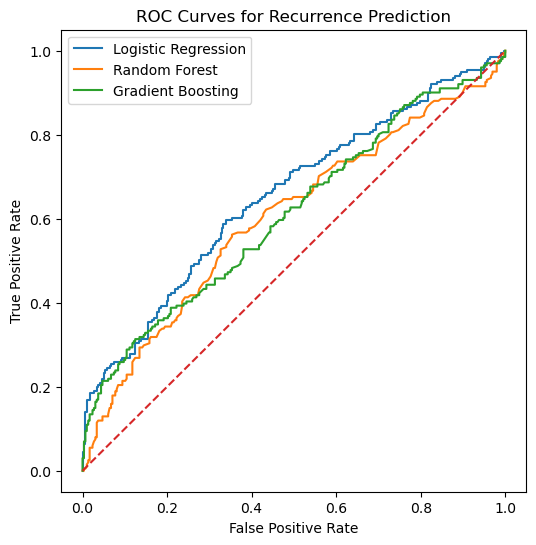

In [74]:
# PART 9: PLOT ROC CURVES FOR ALL MODELS

plt.figure(figsize=(6, 6))

for name, (model, X_tr, X_te) in models.items():
    y_proba = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

# Diagonal line = random guessing
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Recurrence Prediction")
plt.legend()
plt.show()


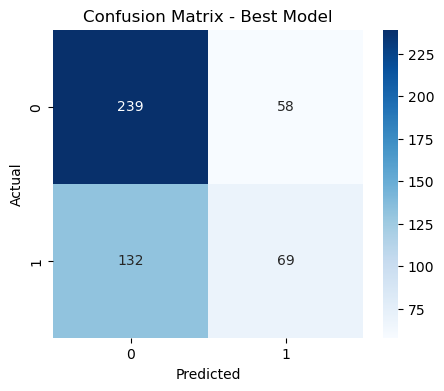

array([[239,  58],
       [132,  69]], dtype=int64)

In [76]:
# PART 10: CONFUSION MATRIX FOR BEST MODEL
#  (I decide: Random Forest or Gradient Boosting)

# For now, I choose Random Forest as the "best model"
# I can change this to "gb" if Gradient Boosting performs better.
best_model = rf
X_test_best = X_test   # Random Forest uses unscaled X_test

# Predictions from best model
y_pred_best = best_model.predict(X_test_best)

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm  # also print raw numbers


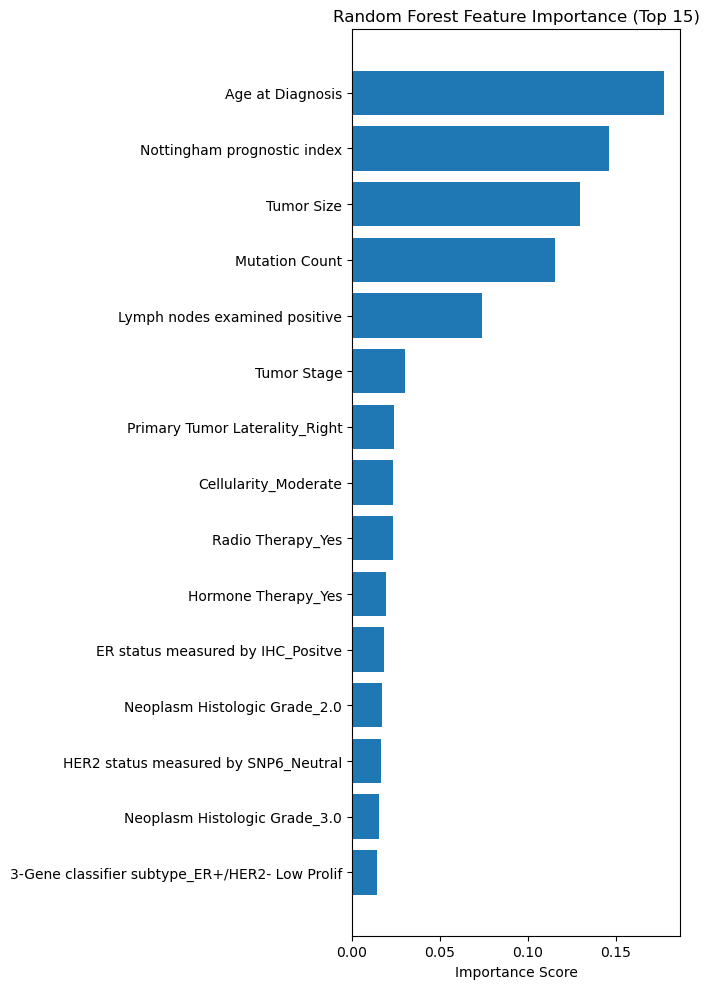

,Feature,Importance
0,Age at Diagnosis,0.177518
5,Nottingham prognostic index,0.146239
1,Tumor Size,0.129650
4,Mutation Count,0.115367
3,Lymph nodes examined positive,0.073872
2,Tumor Stage,0.030173
24,Primary Tumor Laterality_Right,0.024098
7,Cellularity_Moderate,0.023065
20,Radio Therapy_Yes,0.023065
18,Hormone Therapy_Yes,0.019091


In [78]:
# PART 11: BASIC FEATURE IMPORTANCE (Random Forest)
#  This is a simple way to see which features matter most


importances = rf.feature_importances_
feature_names = X_train.columns

# Put in a DataFrame for easier viewing
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot the top 15 most important features
plt.figure(figsize=(7, 10))
plt.barh(fi_df["Feature"].head(15), fi_df["Importance"].head(15))
plt.gca().invert_yaxis()  # so the biggest bar is at the top
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

fi_df.head(15)


In [80]:
# PART 12: SHAP EXPLAINER FOR LOGISTIC REGRESSION
# In this part, I am using SHAP to understand
# how each feature affects my Logistic Regression model.
# I use the scaled data here because Logistic Regression
# was trained on the scaled version of X.

import shap
shap.initjs()

# I use the scaled training data as background for SHAP.
# This tells SHAP what "normal" looks like in my dataset.
X_train_lr = X_train_scaled
X_test_lr  = X_test_scaled

# I create a SHAP explainer for my logistic regression model.
explainer_lr = shap.LinearExplainer(log_reg, X_train_lr)

# Now I ask SHAP to compute explanation values
# for all patients in my test set.
shap_values_lr = explainer_lr.shap_values(X_test_lr)

# Sometimes SHAP returns a list (for multiple classes).
# For binary classification, I only care about the class "1" (recurred),
# so if shap_values_lr is a list, I take the second element.
import numpy as np

if isinstance(shap_values_lr, list):
    shap_values_lr = shap_values_lr[1]

shap_values_lr = np.array(shap_values_lr)

# I print the shapes just to make sure everything matches.
print("SHAP values shape:", shap_values_lr.shape)
print("X_test_lr shape:  ", X_test_lr.shape)
print("Number of features:", X_train.columns.shape[0])


SHAP values shape: (498, 37)
X_test_lr shape:   (498, 37)
Number of features: 37


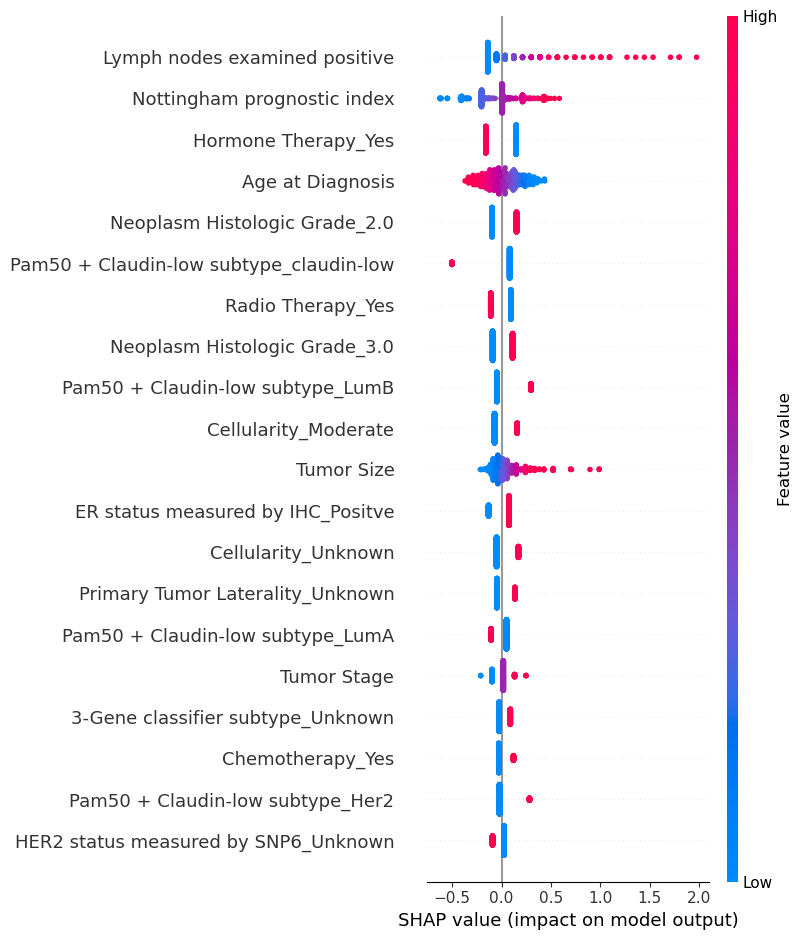

In [82]:
# PART 12a: SHAP SUMMARY PLOT (GLOBAL VIEW)
# This plot helps me see which features matter the most
# across all test patients for my Logistic Regression model.

# - Each row is one feature.
# - Each dot is one patient.
# - Red means the feature value is high.
# - Blue means the feature value is low.

# Dots on the RIGHT push the model toward predicting recurrence (class 1).
# Dots on the LEFT push the model away from predicting recurrence.


shap.summary_plot(
    shap_values_lr,
    X_test_lr,
    feature_names=X_train.columns
)


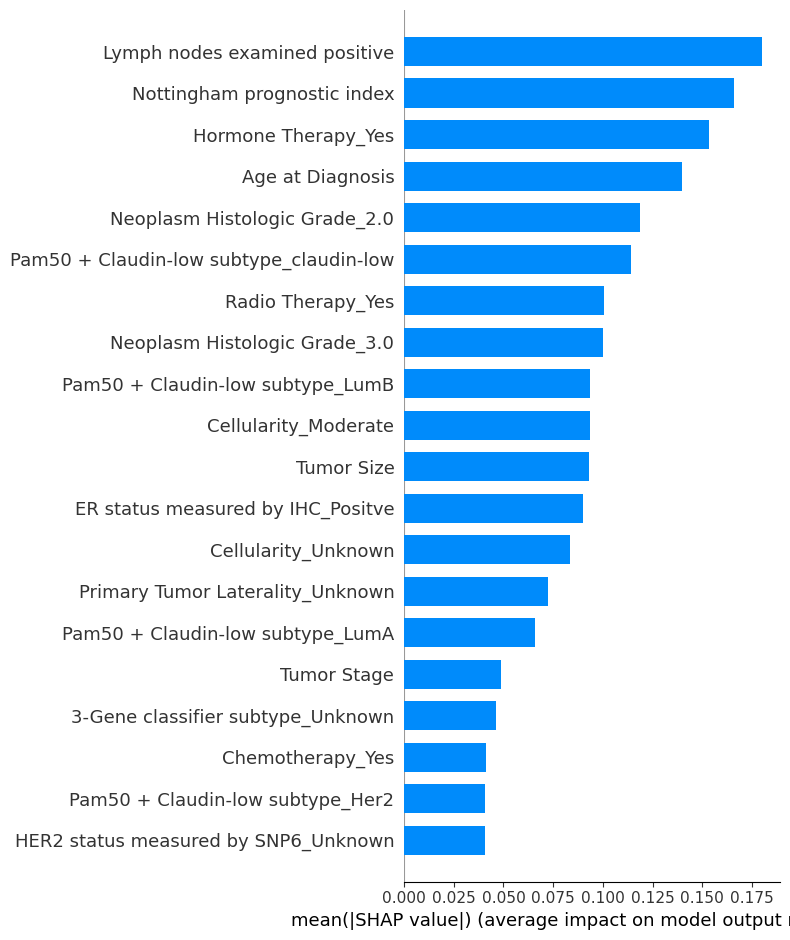

In [84]:
# PART 12b: SHAP BAR PLOT (GLOBAL IMPORTANCE)
# This bar plot summarizes the average impact of each feature
# on the model's predictions.
# Higher bars mean the feature has a stronger overall influence
# on predicting recurrence vs. non-recurrence.


shap.summary_plot(
    shap_values_lr,
    X_test_lr,
    feature_names=X_train.columns,
    plot_type="bar"
)


Top feature according to SHAP: Lymph nodes examined positive


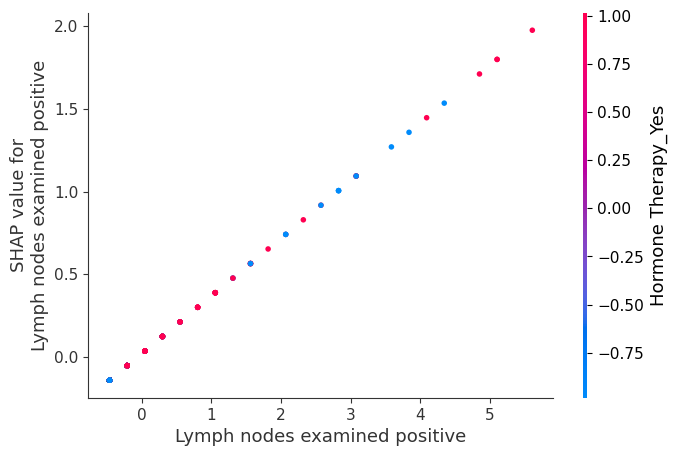

In [86]:
# PART 13: SHAP DEPENDENCE PLOT FOR TOP FEATURE
# In this part, I focus on the single most important feature
# according to SHAP.
# The plot shows:
# - On the x-axis: the actual value of that feature.
# - On the y-axis: how much that feature pushes the model
#   toward or away from predicting recurrence.


# I compute the mean absolute SHAP value per feature
# to find which feature is globally most important.
mean_abs_shap = np.mean(np.abs(shap_values_lr), axis=0)
top_feature_index = np.argmax(mean_abs_shap)
top_feature_name = X_train.columns[top_feature_index]

print("Top feature according to SHAP:", top_feature_name)

# Now I create a dependence plot for this top feature.
shap.dependence_plot(
    top_feature_name,
    shap_values_lr,
    X_test_lr,
    feature_names=X_train.columns
)


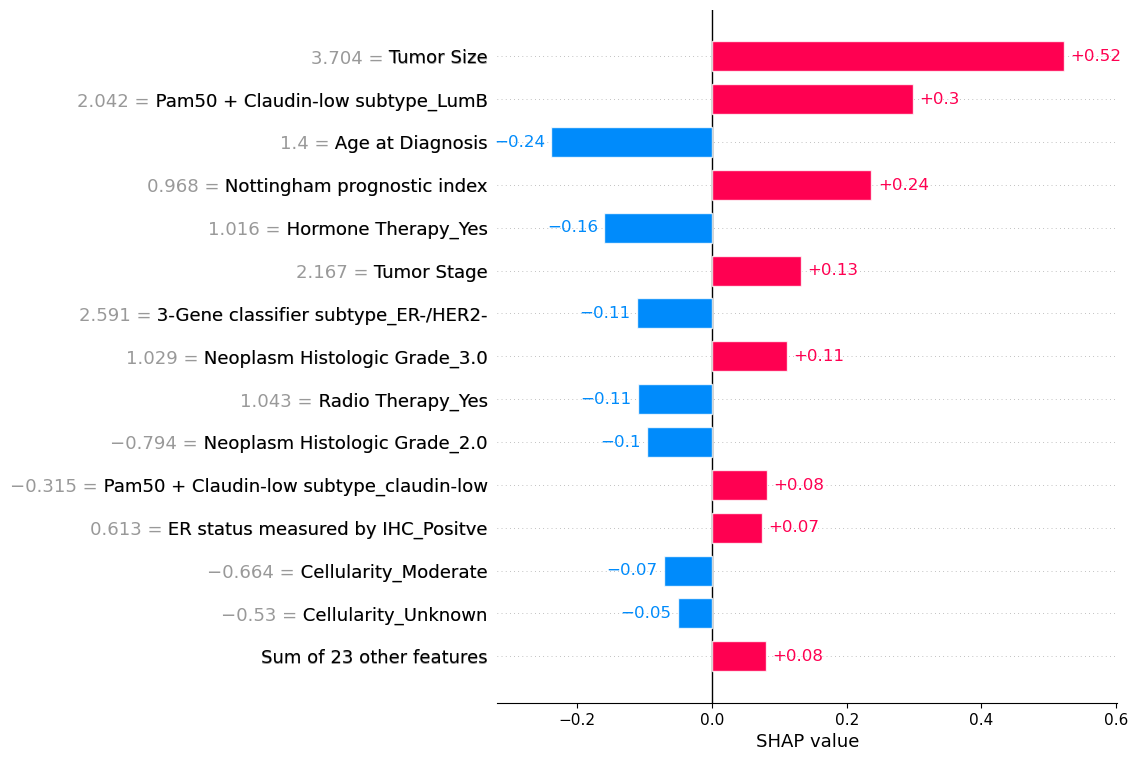

In [88]:
# PART 14: SHAP LOCAL EXPLANATION FOR ONE PATIENT
# Here I pick one patient from the test set
# and explain why the model predicted recurrence or not.

# I can change the index "i" to look at different patients.
# The bar plot shows which features pushed the prediction
# up (toward recurrence) or down (toward no recurrence)

i = 5  # I can change this index to any test patient I want

# I create a SHAP Explanation object for this patient
single_explanation = shap.Explanation(
    values=shap_values_lr[i],
    base_values=explainer_lr.expected_value,
    data=X_test_lr[i],
    feature_names=X_train.columns
)

# I use a bar plot because it is easy to understand and present.
shap.plots.bar(single_explanation, max_display=15)
#plt.title("SHAP Local Explanation – Test Patient {}".format(i))
#plt.show()


In [90]:

# PART 16: LIME EXPLANATION


from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# 1. Create the LIME explainer using training data
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Recurred', 'Recurred'],
    mode='classification'
)

# 2. Choose one patient from the test set
patient_index = 5
patient_data = X_test.iloc[patient_index].values

# 3. Explain the prediction using LIME
lime_exp = explainer.explain_instance(
    data_row=patient_data,
    predict_fn=log_reg.predict_proba   # <-- FIXED
)

# 4. Show LIME explanation
lime_exp.show_in_notebook(show_table=True)
